# Проверка гипотез в бизнесе
В этом проекте мы попробуем себя в роли аналитика крупного сервиса проката самокатов GoFast. Компания предоставила три датасета с данными о пользователях сервиса, их поездках за один год, а также стоимости услуг в подписках. Нас просят проанализировать демографию пользователей и особенности использования самокатов, а также определить возможную выгоду от распространения платной подписки на самокаты.

# Описание данных

Таблица с пользователями `users_go.csv`

- `user_id` — уникальный идентификатор пользователя.

- `name` — имя пользователя.

- `age` — возраст.

- `city` — город.

- `subscription_type` — тип подписки: `free`, `ultra`.

Таблица с поездками `rides_go.csv`

- `user_id` — уникальный идентификатор пользователя.

- `distance` — расстояние в метрах, которое пользователь проехал в текущей сессии.

- `duration` — продолжительность сессии в минутах, то есть время с того момента, как пользователь нажал кнопку «Начать поездку», до того, как он нажал кнопку «Завершить поездку».

- `date` — дата совершения поездки.

Таблица с подписками `subscriptions_go.csv`

- `subscription_type` — тип подписки.

- `minute_price` — стоимость одной минуты поездки по этой подписке.

- `start_ride_price` — стоимость начала поездки.

- `subscription_fee` — стоимость ежемесячного платежа.

---
##  Загрузка данных


In [1]:
# Импортируем библиотеки
import pandas as pd

###  Чтение данных


In [2]:
df_users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
df_rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
df_subscriptions_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv') 

###  Печать первых строк


In [3]:
df_users_go.head(5)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
df_rides_go.head(5)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
df_subscriptions_go.head(5)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


###  Подсчёт строк
Определим количество строк в каждом из трёх датафреймов. Это поможет оценить объём данных и выявить аномалии, например слишком малое количество записей. В качестве ответа запишем три целых числа в одну строку через пробел.

In [6]:
rows_users = len(df_users_go)
rows_rides = len(df_rides_go)
rows_subscriptions = len(df_subscriptions_go)

print(rows_users, rows_rides, rows_subscriptions)

1565 18068 2


---
##  Знакомство с данными и их предварительная подготовка

Прежде чем начать анализ, важно убедиться в качестве предоставленных данных. Выполним несколько шагов, чтобы лучше понять структуру и устранить потенциальные проблемы в таблицах.

###  Определение типов данных
В датафрейме `df_rides_go` выведем типы данных каждой колонки стандартным атрибутом `dtypes`. Так мы проверим корректность типов и подготовите данные для дальнейшей обработки.

In [7]:
print(df_rides_go.dtypes)

user_id       int64
distance    float64
duration    float64
date         object
dtype: object


###  Преобразование формата даты
Приведем столбец `date` в датафрейме `df_rides_go` к типу даты pandas, используя метод `pd.to_datetime()`, изученный нами в одном из прошлых спринтов. Этот шаг упростит работу с временными данными.

In [8]:
df_rides_go['date'] = pd.to_datetime(df_rides_go['date'])

###  Создание столбца с месяцем
На основе столбца `date` создадим новый столбец `month`, содержащий номер месяца. Это нужно для последующей группировки данных и анализа сезонных трендов.

In [9]:
df_rides_go['month'] = df_rides_go['date'].dt.month

###  Поиск дублей и пропусков
В датафрейме пользователей `df_users_go` определим количество пропусков и дубликатов. Это необходимо для понимания полноты и уникальности данных пользователей. Ответ выведеме в виде двух целых чисел, разделённых пробелом. Например: `10 20`.

In [10]:
# Количество пропусков в каждой колонке (суммируем)
missing_values = df_users_go.isnull().sum().sum()

# Количество полных дубликатов строк
duplicates = df_users_go.duplicated().sum()

print(missing_values, duplicates)

0 31


###  Заполнение пропусков и удаление дублей
При наличии пропущенных значений заполним их нулями, а все дубликаты удалим. Это шаг необходим для улучшения качества данных, что является ключевым для точного анализа. Все операции проводем с созданными в рамках задачи 1 датафреймами.

In [11]:
# Заполнение пропусков нулями
df_users_go.fillna(0, inplace=True)

# Удаление дубликатов (оставляем первое вхождение)
df_users_go.drop_duplicates(inplace=True)

### Округление длительности поездки
В датафрейме поездок `df_rides_go` округлим время поездки `duration` до целого числа стандартным методом `round()`. Затем приведе эту колонку к целочисленному типу `int`. Этот шаг затем поможет нам правильно рассчитать прибыль, так как плата взимается только за целое число минут.

In [12]:
df_rides_go['duration'] = df_rides_go['duration'].round()
df_rides_go['duration'] = df_rides_go['duration'].astype(int)

---
##  Исследовательский анализ данных (EDA)
 В этом задании мы внимательнее изучим и визуализируем информацию о географии и демографии сервиса, а также лучше поймём закономерности в дистанциях и длительности поездок.


###  Импорт библиотеки matplotlib
Импортируем библиотеку matplotlib.pyplot с сокращением `plt`.

In [13]:
# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt

###  Количество пользователей по городам.
Пользуясь данными из датафрейма `df_users_go`, изучим количество пользователей в каждом из городов. Создадиме и выведем на экран объект `pd.Series`, названный `users_by_city_count`, с одной колонкой `count` — суммарным количеством пользователей в каждом городе `city`, отсортированным по убыванию.

In [14]:
users_by_city_count = df_users_go['city'].value_counts().sort_values(ascending = False)
print(users_by_city_count)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64


###  Количество пользователей подписки
Создадим и выведем на экран серию `subscription_type_count` с количеством пользователей для каждого типа подписки `subscription_type`.

In [15]:
subscription_type_count = df_users_go['subscription_type'].value_counts()
print(subscription_type_count)

subscription_type
free     835
ultra    699
Name: count, dtype: int64


###  Круговая диаграмма
Построим круговую диаграмму, указав процент пользователей с `free` и `ultra` подпиской. Вызовем метод `plot()` для серии `subscription_type_count` с указанием нужного аргумента для построения круговой диаграммы.

Затем добавим следующее:
- **Заголовок.** Установим заголовок с помощью параметра `title`, задав его как `'Соотношение пользователей с подпиской и без подписки'`.
- **Процентные метки.** Используем параметр `autopct='%.0f%%'` для отображения процентных значений на диаграмме. Достаточно передать аргумент в указанном виде методу `plot()`. Процентные метки часто хорошо дополняют круговые диаграммы.
- **Подпись оси Y.** Установим пустую строку для подписи оси Y `(ylabel='')`, чтобы она не отображалась.
- **Цвета секторов.** Используеме параметр `colors`, задав красный цвет `red` для пользователей без подписки и зелёный `green` для подписчиков.

Затем вызовем `plt.show()` для отображения диаграммы.

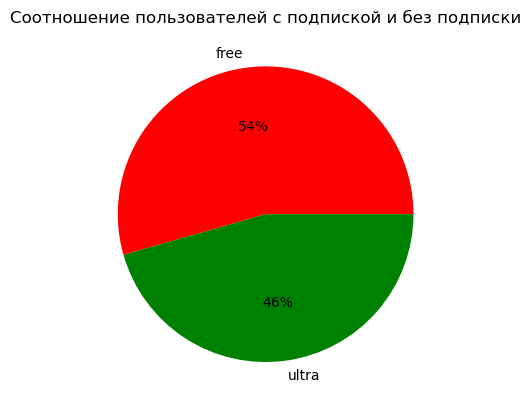

In [16]:
subscription_type_count.plot(
    kind= 'pie',
    title='Соотношение пользователей с подпиской и без подписки',
    autopct='%.0f%%',
    ylabel= '',
    colors=['red','green']
)

plt.show()

###  Гистограмма возрастов
Построим гистограмму возрастов `age` пользователей самокатов. Используем количество бинов, равное разности максимального и минимального значений возраста.

Что нужно сделать:

1. Определить количество бинов `n_bins` как разницу между максимальным и минимальным значениями в столбце `age`.
2. Использовать метод `hist()` для столбца `df_users_go['age']`.
3. Установить количество бинов через параметр `bins=n_bins`.
4. Назначить заголовок графика как `'Возраст пользователей'` с помощью `plt.title()`.
5. Установить подпись оси X как `'Возраст'` с помощью `plt.xlabel()`.
6. Вызвать `plt.show()` для визуального отображения гистограммы.

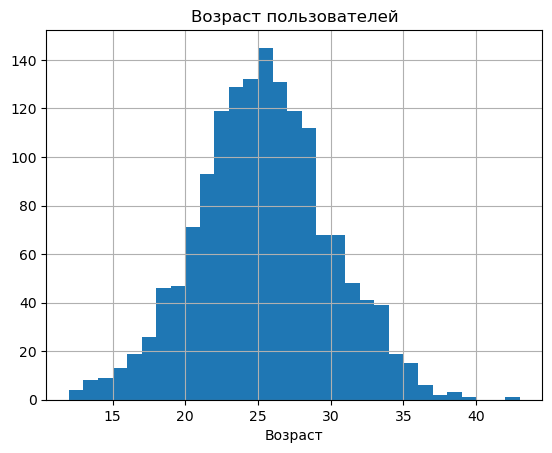

In [17]:
min_age = df_users_go['age'].min()
max_age = df_users_go['age'].max()
n_bins = max_age - min_age

df_users_go['age'].hist(bins = n_bins)

plt.title('Возраст пользователей')
plt.xlabel('Возраст')

plt.show()

###  Несовершеннолетние пользователи
Рассчитаем долю несовершеннолетних (возрастом менее 18 лет) пользователей самокатов.

In [18]:
under_18 = df_users_go[df_users_go['age'] < 18].shape[0]
total = df_users_go.shape[0]
users_under_18_ratio = int((under_18/total)*100)
print(f'Доля несовершеннолетних пользователей самокатов составляет {users_under_18_ratio}%.')

Доля несовершеннолетних пользователей самокатов составляет 5%.


###  Характеристики длительности поездки
Длительность поездки является важной метрикой в работе сервиса проката самокатов. Если средняя длительность поездок будет слишком высокой, самокаты будут быстрее выходить из строя. Если слишком низкой, значит, клиентам что-то не нравится в сервисе.

В этом задании с помощью описательной статистики мы изучим длительность поездок:

1. Используем колонку `duration` из датафрейма `df_rides_go`.
2. Расчитаем среднее значение и стандартное отклонение длительности поездки. Для расчёта стандартного отклонения можно воспользоваться методом `std()`.
3. Рассчитаем 25-й и 75-й процентили длительности поездки.





In [19]:
# Рассчитываем статистические показатели
duration_mean = int(round(df_rides_go['duration'].mean()))  # Среднее -> округляем и в int
duration_std = int(round(df_rides_go['duration'].std()))    # Стандартное отклонение -> округляем и в int
duration_pct25 = int(round(df_rides_go['duration'].quantile(0.25)))  # 25-й процентиль
duration_pct75 = int(round(df_rides_go['duration'].quantile(0.75)))  # 75-й процентиль

print(f'Средняя длительность поездки {duration_mean} минут со стандартным отклонением {duration_std}. Основная часть поездок занимает от {duration_pct25} до {duration_pct75} минут.')

Средняя длительность поездки 18 минут со стандартным отклонением 6. Основная часть поездок занимает от 14 до 22 минут.


---
##  Объединение данных

В самом начале урока мы загрузили три таблицы, настало время объединить все эти данные в один датафрейм.

###  Объединение таблицы пользователей и поездок
Объединим датафреймы с информацией о пользователях `df_users_go` и поездках `df_rides_go`. Полученный датафрейм назовием просто `df`. При объединении используйте метод `merge()` по общей для двух таблиц колонке и тип объединения `left`.

In [20]:
df = pd.merge(df_users_go,df_rides_go,on='user_id',how='left')

### Присоединение информации о подписках
Присоединим к полученному датафрейму `df` информацию о подписках из `df_subscriptions_go`, используя метод `merge()` по общей колонке и тип объединения `left`.


In [21]:
df = df.merge(df_subscriptions_go,on='subscription_type',how='left')

###  Размеры объединённого датафрейма
Для финальной проверки выведем на экран первые пять строк датафрейма, а также количество строк и столбцов полученного датафрейма `df`. Этот этап позволит убедиться, что никакие записи не потерялись при объединении.

In [22]:
# Выводим первые строки датафрейма
display(df.head())

# Выводим количество строк и столбцов в объединённом датафрейме
n_rows, n_cols = df.shape
print(f'В полученном датафрейме {n_rows} строк и {n_cols} столбцов.')

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26,2021-08-28,8,6,0,199


В полученном датафрейме 18068 строк и 12 столбцов.


###  Отдельные датафреймы для пользователей с подпиской и без
Создадим два вспомогательных датафрейма на основе `df`: первый только для пользователей с подпиской `df_ultra` и второй только для пользователей без подписки `df_free`. В следующих задачах два этих датафрейма пригодятся при изучении поведения пользователей с подпиской и без, а также при проверке продуктовых гипотез.

In [23]:
# Создаем датафрейм для пользователей с подпиской ultra
df_ultra = df[df['subscription_type'] == 'ultra'].copy()

# Создаем датафрейм для пользователей с подпиской free
df_free = df[df['subscription_type'] == 'free'].copy()

###  Гистограмма длительности поездок для обоих групп
На одном графике построим гистограмму распределения длительности поездок `duration` для пользователей с подпиской и без.

Что нужно сделать:

1. Установить размер графика: 15 по горизонтали и 5 по вертикали. Использовать `plt.figure(figsize=(15, 5))`.
2. Отобразить данные из столбца `duration` датафрейма `df_free` с помощью метода `hist()`, задав количество бинов `bins=30` и метку `label='free'`.
3. Отобразить данные из столбца `duration` датафрейма `df_ultra` с помощью метода `hist()`, также задав количество бинов `bins=30` и метку `label='ultra'`.
4. Установить подпись оси X как `'Длительность поездки, мин.'`, используя `plt.xlabel()`.
5. Задать заголовок графика как `'Гистограмма распределения длительности поездок'` методом `plt.title()`.
6. Добавить легенду для различения категорий на графике с использованием `plt.legend()`.
7. Вызвать `plt.show()` для показа графика пользователю.

Для удобства воспользуемся датафреймами, созданными на прошлом шаге, — `df_ultra` и `df_free`.

Дополнительно рассчитаем среднюю длительность поездки для пользователей с подпиской и без, округлив ее до целых стандартной функцией `round`

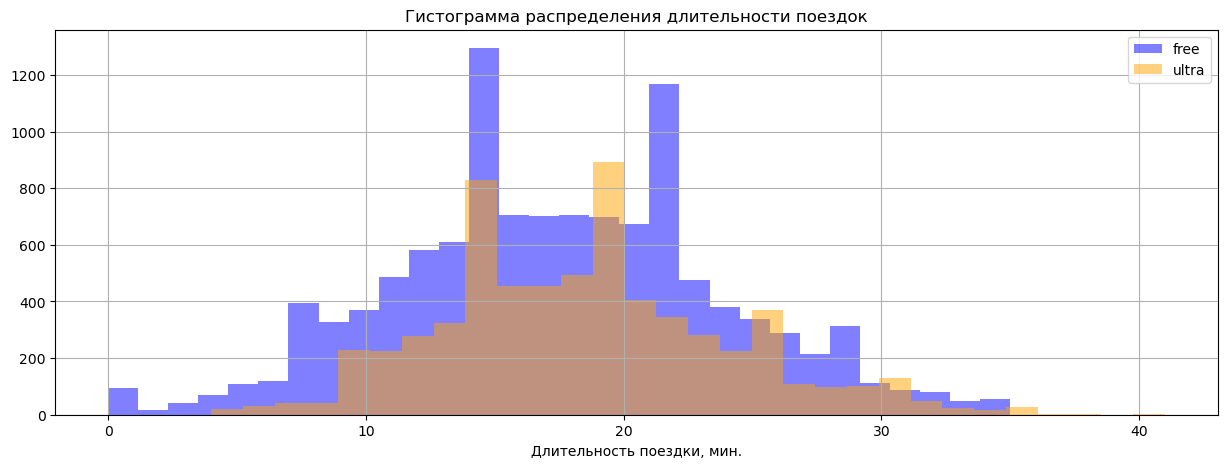

Средняя длительность поездки для пользователей без подписки 17 мин, а для пользователей с подпиской 19 мин


In [24]:
# Гистограмма длительности поездки для пользователей с подпиской и без
plt.figure(figsize=(15, 5))

# Гистограмма для free
df_free['duration'].hist(bins=30, alpha=0.5, label='free', color='blue')

# Гистограмма для ultra
df_ultra['duration'].hist(bins=30, alpha=0.5, label='ultra', color='orange')

plt.xlabel('Длительность поездки, мин.')
plt.title('Гистограмма распределения длительности поездок')
plt.legend()

plt.show()

# Расчет и вывод на экран средней длительности поездки для пользователей с подпиской и без
mean_duration_free = round(df_free['duration'].mean())
mean_duration_ultra = round(df_ultra['duration'].mean())
print(f'Средняя длительность поездки для пользователей без подписки {mean_duration_free} мин, а для пользователей с подпиской {mean_duration_ultra} мин')

---
##  Подсчёт выручки
Данные о количестве и длительности поездок объединены с ценами и тарифами, а значит, теперь есть всё необходимое, чтобы рассчитать важный для бизнеса показатель — выручку.

###  Данные сгруппированные по нужным колонкам
Сгруппируем данные по следующим столбцам: `user_id`, `name`, `subscription_type`, `month`. Группировку призводем в датафрейме `df_gp`. В итоговом датафрейме `df_gp` должен сохраниться порядок агрегации изначальных столбцов и не должны использоваться групповые индексы (опция `as_index=False`).


In [25]:
df_gp = df.groupby(
    ['user_id', 'name', 'subscription_type', 'month'],
    as_index=False
)

###  Подсчёт агрегированных метрик
Создадим новый датафрейм `df_agg`. В нём для каждой группы рассчитаем и добавим в датафрейм следующие агрегированные значения, используя метод `agg()`:
- `total_distance` — сумма значений в столбце `distance`.
- `total_duration` — сумма значений в столбце `duration`.
- `rides_count` — количество элементов в столбце `duration`.
- `subscription_type` — первое значение в группе для столбца `subscription_type`.
- `minute_price` — первое значение в группе для столбца `minute_price`.
- `start_ride_price` — первое значение в группе для столбца `start_ride_price`.
- `subscription_fee` — первое значение в группе для столбца `subscription_fee`.

In [26]:
df_agg = df_gp.agg(
    total_distance=('distance', 'sum'),
    total_duration= ('duration', 'sum'),
    rides_count= ('duration', 'count'),
    subscription_type= ('subscription_type','first'),
    minute_price= ('minute_price','first'),
    start_ride_price= ('start_ride_price','first'),
    subscription_fee= ('subscription_fee','first'),
)

### Функция для подсчёта выручки
Создадим функцию `calculate_monthly_revenue(row)` для расчёта месячной выручки по формуле:

`monthly_revenue` = `start_ride_price` * `rides_count` + `minute_price` * `total_duration` + `subscription_fee`

В качестве входных данных функция будет принимать одну строку `row` датафрейма. Вспомните, как в таком случае обращаться к каждой колонке.

Здесь:
- `start_ride_price * rides_count` — выручка от начала каждой поездки.
- `minute_price * total_duration` — выручка за время использования.
- `subscription_fee` — фиксированная выручка от подписок.

In [27]:
def calculate_monthly_revenue(row):
    return (
        row['start_ride_price'] * row['rides_count'] +
        row['minute_price'] * row['total_duration'] + 
        row['subscription_fee']
    )

# Применяем функцию и сохраняем результат в новой переменной
monthly_revenue = df_agg.apply(calculate_monthly_revenue, axis=1)

### Создание столбца с месячной выручкой на пользователя
Создадим новый столбец с месячной выручкой на пользователя `monthly_revenue`. Для этого применм функцию `calculate_monthly_revenue(row)` к каждой строке агрегированного датафрейма `df_agg`.

In [28]:
# Применяем функцию и создаём новый столбец monthly_revenue
df_agg['monthly_revenue'] = df_agg.apply(calculate_monthly_revenue, axis=1)

###  Поиск пользователя с максимальной выручкой
Исследуем полученные значения выручки. Найдем пользователя с максимальной суммарной выручкой за весь период наблюдения и для него выведем на экран `user_id`, имя, месяц, количество поездок и выручку за каждый из месяцев.

In [29]:
# 1. Находим пользователя с максимальной суммарной выручкой
max_revenue_user_id = df_agg.groupby('user_id')['monthly_revenue'].sum().idxmax()

# 2. Получаем все записи этого пользователя
max_user_data = df_agg[df_agg['user_id'] == max_revenue_user_id].sort_values('month')

# 3. Выводим результат с ВСЕМИ требуемыми столбцами
print(max_user_data[['user_id', 'name', 'month', 'rides_count', 'monthly_revenue']].to_string())

      user_id       name  month  rides_count  monthly_revenue
8877     1236  Александр      1            2              228
8878     1236  Александр      2            3              614
8879     1236  Александр      3            5              762
8880     1236  Александр      4            1              202
8881     1236  Александр      5            3              574
8882     1236  Александр      6            1              282
8883     1236  Александр      7            1              290
8884     1236  Александр      8            2              452
8885     1236  Александр      9            1              122
8886     1236  Александр     10            3              430
8887     1236  Александр     11            3              494
8888     1236  Александр     12            2              476


---
##  Проверка гипотез

###  Импорт библиотеки SciPy
Импортируем библиотеку `scipy.stats` с сокращением `st`.

In [30]:
import scipy.stats as st

### Вспомогательная функция для интерпретации результатов
Напишем вспомогательную функцию `print_stattest_results(p_value, alpha)`, которая будет интерпретировать результаты статистического теста на основе p-value и заданного уровня значимости (α-уровня). Функция должна решать, следует ли принять альтернативную гипотезу или сохранить нулевую гипотезу.

У функции два параметра:
- `p_value` (тип `float`) — значение p-value, полученное в результате выполнения статистического теста.
- `alpha` (тип `float`, необязательный, по умолчанию `alpha = 0.05`) — уровень значимости статистического теста, который используется как порог для принятия решения об отклонении нулевой гипотезы.

Если мы принимаем альтернативную гипотезу, нужно вывести сообщение:
`'Полученное значение p_value=<Введённое значение p_value> меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.'`

Если мы не можем опровергнуть нулевую гипотезу, нужно вывести сообщение: `'Полученное значение p_value=<Введённое значение p_value> больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.'`

Вызовем функцию для `p_value = 0.0001` и `p_value = 0.1`.

In [31]:
def print_stattest_results(p_value: float, alpha: float = 0.05):
    if p_value < alpha:
        print(f'Полученное значение p_value={p_value} меньше критического уровня alpha={alpha}. '
              'Принимаем альтернативную гипотезу.')
    else:
        print(f'Полученное значение p_value={p_value} больше критического уровня alpha={alpha}. '
              'Опровергнуть нулевую гипотезу нельзя.')
print_stattest_results(p_value=0.0001)
print_stattest_results(p_value=0.1)

Полученное значение p_value=0.0001 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Полученное значение p_value=0.1 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.


###  Длительность для пользователей с подпиской и без

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Сформулируем нулевую и альтернативную гипотезы:
- Нулевая гипотеза (Н0): Среднее время поездки у пользователей с подпиской и без подписки одинаковое.
- Альтернативная гипотеза (Н1): Среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки.

Чтобы проверить эту гипотезу:
1. Используеме неагрегированные данные из датафреймов `df_ultra` и `df_free`, созданные на одном из прошлых шагов.
2. Используем данные о продолжительности каждой поездки `duration` — отдельно для подписчиков и тех, у кого нет подписки.
3. Рассчитаем значение `p_value` для выбранной гипотезы, используя функции модуля `scipy.stats` и односторонний t-тест.
4. В качестве результата вызовем написанную функцию `print_stattest_results(p_value, alpha)`, передав ей рассчитанное значение `p_value`.
5. В конце дополнительно рассчитаем среднюю длительность поездки для тарифов `ultra` и `free`, округлив её до двух знаков после точки стандартной функцией `round()`.

In [32]:
ultra_duration = df_ultra['duration']
free_duration = df_free['duration']

results = st.ttest_ind (ultra_duration, free_duration, alternative= 'greater') # Укажите подходящий инструмент здесь
p_value = results.pvalue
print_stattest_results(p_value)
ultra_mean_duration = round(ultra_duration.mean(),2)
free_mean_duration = round(free_duration.mean(),2)

print(f'Средняя длительность поездки тарифа Ultra {ultra_mean_duration}')
print(f'Средняя длительность поездки тарифа Free {free_mean_duration}')

Полученное значение p_value=3.1600689435611813e-35 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Средняя длительность поездки тарифа Ultra 18.55
Средняя длительность поездки тарифа Free 17.39


###  Длительность поездки: больше или меньше критического значения

Проанализируем ещё одну важную продуктовую гипотезу. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров?

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза (Н0): Средняя дистанция поездки у пользователей с подпиской равна 3130 м.

- Альтернативная гипотеза (Н1): Средняя дистанция поездки у пользователей с подпиской больше 3130 м.

Чтобы проверить эту гипотезу:

1. Используем неагрегированные данные о каждой поездке пользователей с подпиской из датафрейма `df_ultra`.

2. Используем данные о дистанции каждой поездки `distance`.

3. Рассчитаем значение `p_value` для выбранной гипотезы, используя функции модуля `scipy.stats` и односторонний t-тест. Подумаем, как применить эту функцию, если необходимо проверить равенство с одним значением.

4. В качестве результата вызовем написанную функцию `print_stattest_results(p_value, alpha)`, передав ей рассчитанное значение `p_value`.

In [33]:
null_hypothesis = 3130
ultra_distance = df_ultra['distance']

results = st.ttest_1samp(ultra_distance , null_hypothesis,alternative = 'greater')
p_value = results.pvalue
print_stattest_results(p_value)

Полученное значение p_value=0.9195368847849785 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.


### Прибыль от пользователей с подпиской и без
Проверим гипотезу о том, что выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза (Н0): Средняя месячная выручка у пользователей с подпиской и без подписки одинаковая.
- Альтернативная гипотеза (Н1): Средняя месячная выручка у пользователей с подпиской выше, чем у пользователей без подписки.

Чтобы проверить эту гипотезу:
1. Используем агрегированные данные из датафрейма `df_agg`, подготовленного на шаге 5.
2. Используем исходные данные о месячной выручке от каждого пользователя — `monthly_revenue`.
3. Рассчитаем значение `p_value` для выбранной гипотезы, используя функции модуля `scipy.stats` и односторонний t-тест.
4. В качестве результата вызовем написанную функцию `print_stattest_results(p_value, alpha)`, передав ей рассчитанное значение `p_value`.
5. Дополнительно рассчитаем среднюю выручку для тарифов `ultra` и `free`, округлив её до целого стандартной функцией `round()`.

In [34]:
revenue_ultra = df_agg[df_agg['subscription_type']=='ultra']['monthly_revenue']
revenue_free = df_agg[df_agg['subscription_type']=='free']['monthly_revenue']

results = st.ttest_ind(revenue_ultra,revenue_free,alternative = 'greater')
p_value = results.pvalue
print_stattest_results(p_value)

mean_revenue_ultra = round(revenue_ultra.mean())
mean_revenue_free = round(revenue_free.mean())

print(f'Средняя выручка подписчиков Ultra {mean_revenue_ultra} руб')
print(f'Средняя выручка подписчиков Free {mean_revenue_free} руб')

Полученное значение p_value=1.7274069878387966e-37 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Средняя выручка подписчиков Ultra 359 руб
Средняя выручка подписчиков Free 322 руб


---
##  Распределения

В компании возникла идея предлагать дополнительную скидку подписчикам, совершающим длительные поездки продолжительностью более 30 минут. Нас просят оценить долю таких поездок.

В одном из предыдущих заданий мы уже построили гистограмму распределения длительности поездок для выборки. Однако эти данные охватывают лишь часть пользователей всех самокатов, а нас интересуют возможные значения для всей генеральной совокупности. Учитывая, что у нас нет доступа ко всем данным о поездках, было решено смоделировать длительность поездки с помощью нормального распределения, используя в качестве параметров выборочное среднее и стандартное отклонение из доступных данных о поездках.

###  Расчёт выборочного среднего и стандартного отклонения

1. Расчитаем среднюю длительность поездки и сохраните в переменную `mu`.
2. Вычислим стандартное отклонение длительности `duration` и сохраним в переменную `sigma`. Для вычисления стандартного отклонения можно применить метод `std()` к столбцу датасета.
3. Зададим значение переменной `target_time`, равное `30`. Эта переменная будет использоваться для последующего вычисления вероятности.
4. Выведем текстовый вывод по шаблону. При этом округлим оба значения до одного знака после точки стандартной функцией `round()`. Сами значения переменных должны остаться неимзменными для последующих задач.

In [35]:
# Вычисляем среднее значение
mu = df_ultra['duration'].mean()

# Вычисляем стандартное отклонение
sigma = df_ultra['duration'].std()

# Задаём целевое время
target_time = 30

# Делаем вывод
print(f'Средняя длительность поездки {round(mu, 1)}, стандартное отклонение {round(sigma)}.')

Средняя длительность поездки 18.5, стандартное отклонение 6.


### Вычисление значения функции распределения в точке (CDF)
Если вычислить значение функции распределения в точке, это позволит узнать вероятность того, что случайная величина примет значение меньше заданного либо равное ему. Соответственно, если мы хотим ответить на вопрос о вероятности поездки более 30 минут, потребуется использовать CDF.

1. Используем функцию `norm()` из библиотеки SciPy для создания нормального распределения с параметрами `mu` и `sigma`.

2. Применим метод `cdf()` к целевому времени `target_time` для получения вероятности того, что случайная величина будет меньше этого значения или равна ему. Полученное значение сохраним в переменную `prob`, округлив до трёх знаков после точки стандартной функцией `round()`.
3. Выведем на экран текстовый ответ по шаблону.

In [36]:
# Вычисляем вероятность того, что случайная величина будет меньше указанного значения или равна ему


duration_norm_dist  = st.norm(mu,sigma)
prob_leq_30 = duration_norm_dist.cdf(target_time)
prob = round(1 - prob_leq_30, 3) # Используем CDF для нахождения накопленной вероятности

print(f'Вероятность поездки более 30 минут {prob}')

Вероятность поездки более 30 минут 0.02


###  Вероятность для интервала (CDF)
Коллеги посчитали, что процент пользователей, для которых будет показана скидка, недостаточно большой и вряд ли поможет в увеличении лояльности клиентов. Дополнительно нас просят проверить, какой процент пользователей совершает поездки в интервале от 20 до 30 минут. Возможно, именно для них стоит провести промоакцию?

Для этого:

1. Создадим переменные `low` и `high`, указывающие на начало и конец интересующего временного интервала. В этом случае они равны 20 и 30 минут.
2. Используем кумулятивную функцию распределения (CDF) для объекта `duration_norm_dist`, чтобы вычислить вероятность достижения верхней границы (`high`) и нижней границы (`low`).
3. Вычислим вероятность попадания в интервал, округлим до трёх знаков после точки стандартной функцией `round()` и сохраните в переменную `prob_interval`.
4. Выведем ответ, используя шаблон.

In [37]:
# Определяем границы интервала
low = 20
high = 30

prob_low = duration_norm_dist.cdf(low)
prob_high = duration_norm_dist.cdf(high)

# Вычисляем вероятность попадания в интервал
prob_interval = round(prob_high - prob_low, 3)

# Выводим результат
print(f'Вероятность того, что пользователь совершит поездку длительностью от {low} до {high} минут: {prob_interval}')

Вероятность того, что пользователь совершит поездку длительностью от 20 до 30 минут: 0.377


### Определение критической дистанции поездок (PPF)
Длительные поездки могут негативно сказываться на сроке службы самоката. В связи с этим принято решение установить критическую дистанцию, превышение которой будет сопровождаться дополнительной платой. Для этого необходимо определить расстояние, которое превышается только в 10% поездок (90-й процентиль).

Наша задача — смоделировать распределение длительности поездок, предполагая, что оно подчиняется нормальному закону, и рассчитать критическую дистанцию, ниже которой находится 90% всех поездок.

Для этого:
1. Рассчитаем среднюю дистанцию поездки для всех пользователей из датафрейма `df` (с подпиской и без) и сохраним в переменную `mu`.
2. Вычислим стандартное отклонение дистанции поездки `distance` и сохраним в переменную `sigma`. Для вычисления стандартного отклонения можно применить метод `std()` к столбцу датасета.
3. Зададим значение переменной `target_prob`, равное `0.90`. Эта переменная будет использоваться для последующего вычисления критической дистанции.
4. Создадим объект нормального распределения `distance_norm` с заданными значениями `mu` и `sigma`.
5. Применим к созданному нормальному распределению `distance_norm` метод `ppf()` и в качестве аргумента передадим целевую вероятность `target_prob`. Полученное значение сохранм в переменную `critical_distance`.
6. Выведем ответ, используя шаблон.



In [38]:
# Вычисляем среднее значение
mu = df['distance'].mean()

# Вычисляем стандартное отклонение
sigma = df['distance'].std()

# Вероятность, для которой хотим найти значение (90% случаев)
target_prob = 0.90

# Создаём объект нормального распределения
distance_norm = st.norm(mu,sigma)

# Рассчитываем критическую дистанцию для заданного процентиля поездок
critical_distance = distance_norm.ppf(target_prob)

print(f'{100 * target_prob} % поездок имеют дистанцию ниже критического значения {critical_distance:.2f} М.')

90.0 % поездок имеют дистанцию ниже критического значения 4501.94 М.
